# Querying connectivity at a previous time

In this example, we'll see how to query the connectivity among a group of neurons at a previous timepoint in the segmentation. This can be useful for evaluating how proofreading has affected connectivity.


First, we'll need to initialize a CAVE client, here for the "minnie65_phase3_v1" dataset.
If you don't have access to this dataset you can plug in your own dataset and neurons to
follow along.


In [1]:
import caveclient as cc
import pandas as pd

client = cc.CAVEclient("minnie65_phase3_v1")

Then, we'll select a group of neurons to query.


In [2]:
current_timestamp = pd.to_datetime("2024-03-22", utc=True)

query_neurons = client.materialize.query_table(
    "connectivity_groups_v795", timestamp=current_timestamp
)

current_root_ids = query_neurons["pt_root_id"].values

It can be helpful to create a table to keep track of these neurons.


In [3]:
object_table = pd.DataFrame()
object_table["current_root_id"] = current_root_ids

It's often safer to work with these neurons in terms of their IDs in the nucleus table,
rather than their root IDs, since root IDs are dynamic as the segmentation changes.


In [4]:
current_nucs = client.materialize.query_table(
    "nucleus_detection_v0",
    filter_in_dict={"pt_root_id": object_table["current_root_id"]},
)
object_table["target_id"] = object_table["current_root_id"].map(
    current_nucs.set_index("pt_root_id")["id"]
)

Now, let's say I am interested in the connectivity of these neurons at a previous point
in time, before they were as proofread as they are now, say.


In [5]:
past_timestamp = pd.to_datetime("2021-07-01 00:00:00", utc=True)

One option is to look up the supervoxel at the nucleus which anchors each neuron, and
then find the root ID associated with that supervoxel at the previous timepoint using
`chunkedgraph.get_roots`.


In [6]:
object_table["pt_supervoxel_id"] = object_table["target_id"].map(
    current_nucs.set_index("id")["pt_supervoxel_id"]
)
object_table["past_root_from_chunkedgraph"] = client.chunkedgraph.get_roots(
    object_table["pt_supervoxel_id"], timestamp=past_timestamp
)
object_table.head()

,current_root_id,target_id,pt_supervoxel_id,past_root_from_chunkedgraph
0,864691134886015738,307287,90095770694723323,864691135994740394
1,864691134886016762,264920,89033642126703313,864691135463706181
2,864691134948652540,304990,91218852700367385,864691135104201293
3,864691135013445270,262779,88116305764513351,864691135771839483
4,864691135082074103,309480,90237538975205295,864691136820286062


Another option is to simply look up the nucleus detection table again, but at the
previous timestamp. Since the "id" column of the nucleus table is fixed over time, we
can use this to still find our same neurons. However, the `"pt_root_id"` column will be
appropriately updated for the previous time. Under the hood, the materialization
service is doing something very similar to what we just did above.


In [7]:
past_nucs = client.materialize.query_table(
    "nucleus_detection_v0",
    filter_in_dict={"id": object_table["target_id"]},
    timestamp=past_timestamp,
)
object_table["past_root_from_table"] = object_table["target_id"].map(
    past_nucs.set_index("id")["pt_root_id"]
)
object_table.head()

,current_root_id,target_id,pt_supervoxel_id,past_root_from_chunkedgraph,past_root_from_table
0,864691134886015738,307287,90095770694723323,864691135994740394,864691135994740394
1,864691134886016762,264920,89033642126703313,864691135463706181,864691135463706181
2,864691134948652540,304990,91218852700367385,864691135104201293,864691135104201293
3,864691135013445270,262779,88116305764513351,864691135771839483,864691135771839483
4,864691135082074103,309480,90237538975205295,864691136820286062,864691136820286062


Now that we have the correct root IDs, we can look up the connectivity of these neurons
at the previous timepoint.


In [8]:
past_synapse_table = client.materialize.synapse_query(
    pre_ids=object_table["past_root_from_table"],
    post_ids=object_table["past_root_from_table"],
    timestamp=past_timestamp,
    metadata=False,
    remove_autapses=True,
)
past_synapse_table.head()

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position
0,192196222,t,91847292382414612,864691136483104556,91847292382411479,864691135278402209,7116,"[196768, 180870, 22001]","[196642, 180778, 21997]","[196696, 180818, 21997]"
2,176190719,t,90088554813976132,864691135758647630,90018186069801271,864691135463706181,520,"[183858, 184308, 21704]","[183762, 184360, 21703]","[183802, 184340, 21704]"
3,168965450,t,89455854658597948,864691135684173751,89455854658597168,864691135526220635,3060,"[179674, 188938, 22052]","[179714, 189086, 22053]","[179682, 189010, 22054]"
4,138886137,t,87625648633760117,864691135560721377,87625648633752024,864691136105679065,1716,"[166130, 184086, 20864]","[166110, 184192, 20852]","[166116, 184143, 20860]"
5,169732594,t,90021622110760786,864691135446864980,90021622110766822,864691136903347634,760,"[183348, 209754, 22244]","[183400, 209816, 22248]","[183379, 209803, 22246]"


Now we can remap these synapses back to the target IDs of these neurons.


In [9]:
past_synapse_table["pre_target_id"] = past_synapse_table["pre_pt_root_id"].map(
    past_nucs.set_index("pt_root_id")["id"]
)
past_synapse_table["post_target_id"] = past_synapse_table["post_pt_root_id"].map(
    past_nucs.set_index("pt_root_id")["id"]
)
past_synapse_table.head()

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,pre_target_id,post_target_id
0,192196222,t,91847292382414612,864691136483104556,91847292382411479,864691135278402209,7116,"[196768, 180870, 22001]","[196642, 180778, 21997]","[196696, 180818, 21997]",301218,301245
2,176190719,t,90088554813976132,864691135758647630,90018186069801271,864691135463706181,520,"[183858, 184308, 21704]","[183762, 184360, 21703]","[183802, 184340, 21704]",292831,264920
3,168965450,t,89455854658597948,864691135684173751,89455854658597168,864691135526220635,3060,"[179674, 188938, 22052]","[179714, 189086, 22053]","[179682, 189010, 22054]",262957,301101
4,138886137,t,87625648633760117,864691135560721377,87625648633752024,864691136105679065,1716,"[166130, 184086, 20864]","[166110, 184192, 20852]","[166116, 184143, 20860]",296738,264891
5,169732594,t,90021622110760786,864691135446864980,90021622110766822,864691136903347634,760,"[183348, 209754, 22244]","[183400, 209816, 22248]","[183379, 209803, 22246]",306988,305048


For comparison, let's get the connectivity at the current timepoint as well.


In [10]:
current_synapse_table = client.materialize.synapse_query(
    pre_ids=object_table["current_root_id"],
    post_ids=object_table["current_root_id"],
    timestamp=current_timestamp,
    metadata=False,
    remove_autapses=True,
)
current_synapse_table["pre_target_id"] = current_synapse_table["pre_pt_root_id"].map(
    current_nucs.set_index("pt_root_id")["id"]
)
current_synapse_table["post_target_id"] = current_synapse_table["post_pt_root_id"].map(
    current_nucs.set_index("pt_root_id")["id"]
)
current_synapse_table.head()

,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position,pre_target_id,post_target_id
0,158842100,2020-11-04 10:11:44.081977+00:00,NaN,t,4388,89443553671426299,864691135988854016,89443553671436885,864691135954940424,"[179326, 97414, 20932]","[179398, 97350, 20942]","[179384, 97362, 20935]",286913,298829
1,165734548,2020-11-04 12:23:36.262518+00:00,NaN,t,6576,89585665549193435,864691135132887456,89656034293401150,864691135954940424,"[180702, 107566, 20837]","[180782, 107514, 20835]","[180705, 107472, 20831]",291122,298829
2,158842111,2020-11-04 08:54:49.063458+00:00,NaN,t,4276,89443965988207944,864691135132887456,89443965988211818,864691135954940424,"[179392, 100252, 20907]","[179354, 100168, 20909]","[179375, 100224, 20905]",291122,298829
3,190566409,2020-11-04 09:36:44.611944+00:00,NaN,t,4800,91429477896378071,864691136925825354,91429409176924802,864691135954940424,"[193774, 213248, 21169]","[193866, 213094, 21169]","[193832, 213172, 21166]",305233,298829
4,146779077,2020-11-04 06:48:58.480065+00:00,NaN,t,2060,88183994449076026,864691136618908301,88183994449070795,864691136912943345,"[170220, 149736, 21140]","[170322, 149746, 21131]","[170248, 149706, 21132]",258293,256426


For visualization, let's construct the adjacency matrices for both timepoints. Here,
we'll use the count of synapses as the "edge weight". There are many ways to do this;
here we'll use the `pd.crosstab` function.


In [11]:
current_adjacency = pd.crosstab(
    current_synapse_table["pre_target_id"],
    current_synapse_table["post_target_id"],
)

past_adjacency = pd.crosstab(
    past_synapse_table["pre_target_id"],
    past_synapse_table["post_target_id"],
)

index = object_table["target_id"].values

current_adjacency = current_adjacency.reindex(index=index, columns=index).fillna(0)
past_adjacency = past_adjacency.reindex(index=index, columns=index).fillna(0)
diff_adjacency = current_adjacency - past_adjacency

Finally, let's visualize the adjacency matrices, as well as the differences between them.


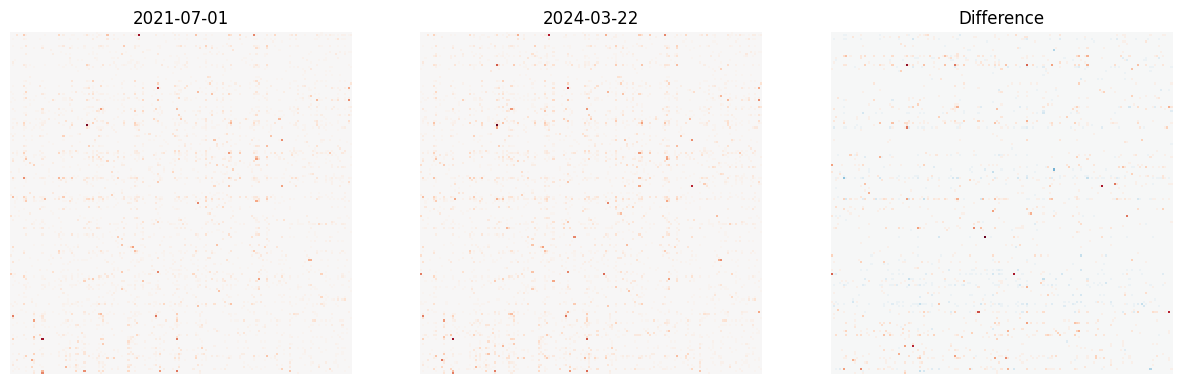

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

vmax = max(current_adjacency.max().max(), past_adjacency.max().max())

heatmap_kws = dict(
    cmap="RdBu_r",
    center=0,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cbar=False,
)

ax = axs[0]
sns.heatmap(
    past_adjacency,
    ax=ax,
    vmax=vmax,
    **heatmap_kws,
)
ax.set(xlabel="", ylabel="", title=past_timestamp.strftime("%Y-%m-%d"))

ax = axs[1]
sns.heatmap(
    current_adjacency,
    ax=ax,
    vmax=vmax,
    **heatmap_kws,
)
ax.set(xlabel="", ylabel="", title=current_timestamp.strftime("%Y-%m-%d"))

ax = axs[2]
sns.heatmap(
    diff_adjacency,
    ax=ax,
    **heatmap_kws,
)
_ = ax.set(xlabel="", ylabel="", title="Difference")